In [88]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline                          
sns.set(color_codes=True)                   

In [89]:
import os
# excel_file_path = os.path.join(os.getcwd(), 'price_history.xlsx')
# df_xlsx = pd.read_excel(excel_file_path)
csv_file_path = os.path.join(os.getcwd(), 'data_csv_file.csv')
# df_xlsx.to_csv(csv_file_path, index=False)
df = pd.read_csv(csv_file_path)
print(df.head())

         Exchange Date    Close    Net      %Chg     Open      Low     High
0  2024-04-22 00:00:00  1067.81   5.08  0.004780  1063.63  1061.95  1069.61
1  2024-04-19 00:00:00  1062.73 -15.16 -0.014065  1077.39  1054.16  1077.51
2  2024-04-18 00:00:00  1077.89   3.02  0.002810  1076.24  1072.81  1083.88
3  2024-04-17 00:00:00  1074.87   3.81  0.003557  1070.80  1070.46  1076.86
4  2024-04-16 00:00:00  1071.06 -20.72 -0.018978  1091.60  1070.13  1091.64


In [90]:
df['Exchange Date'] = pd.to_datetime(df['Exchange Date'], errors='coerce') # Transforming data in timestamps.
df = df.dropna(subset=['Exchange Date']) # Removing invalid dates. (such as 30th feb)

In [91]:
print(df.shape)

(941, 7)


In [92]:
duplicate_rows_df = df[df.duplicated()] 
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (1, 7)


In [93]:
df = df.drop_duplicates(keep='last') # Removing duplicate rows.
print(df.shape)

(940, 7)


!Check if any dates are missing below!. // (should check if weekdays are included)

In [94]:
daily_data = pd.DataFrame(pd.date_range(start=df['Exchange Date'].min(),end=df['Exchange Date'].max()))
daily_data.rename(columns={ daily_data.columns[0]: "Date" }, inplace = True)
daily_data.describe()

,Date
count,1315
mean,2022-07-05 00:00:00
min,2020-09-16 00:00:00
25%,2021-08-10 12:00:00
50%,2022-07-05 00:00:00
75%,2023-05-29 12:00:00
max,2024-04-22 00:00:00


# EDA

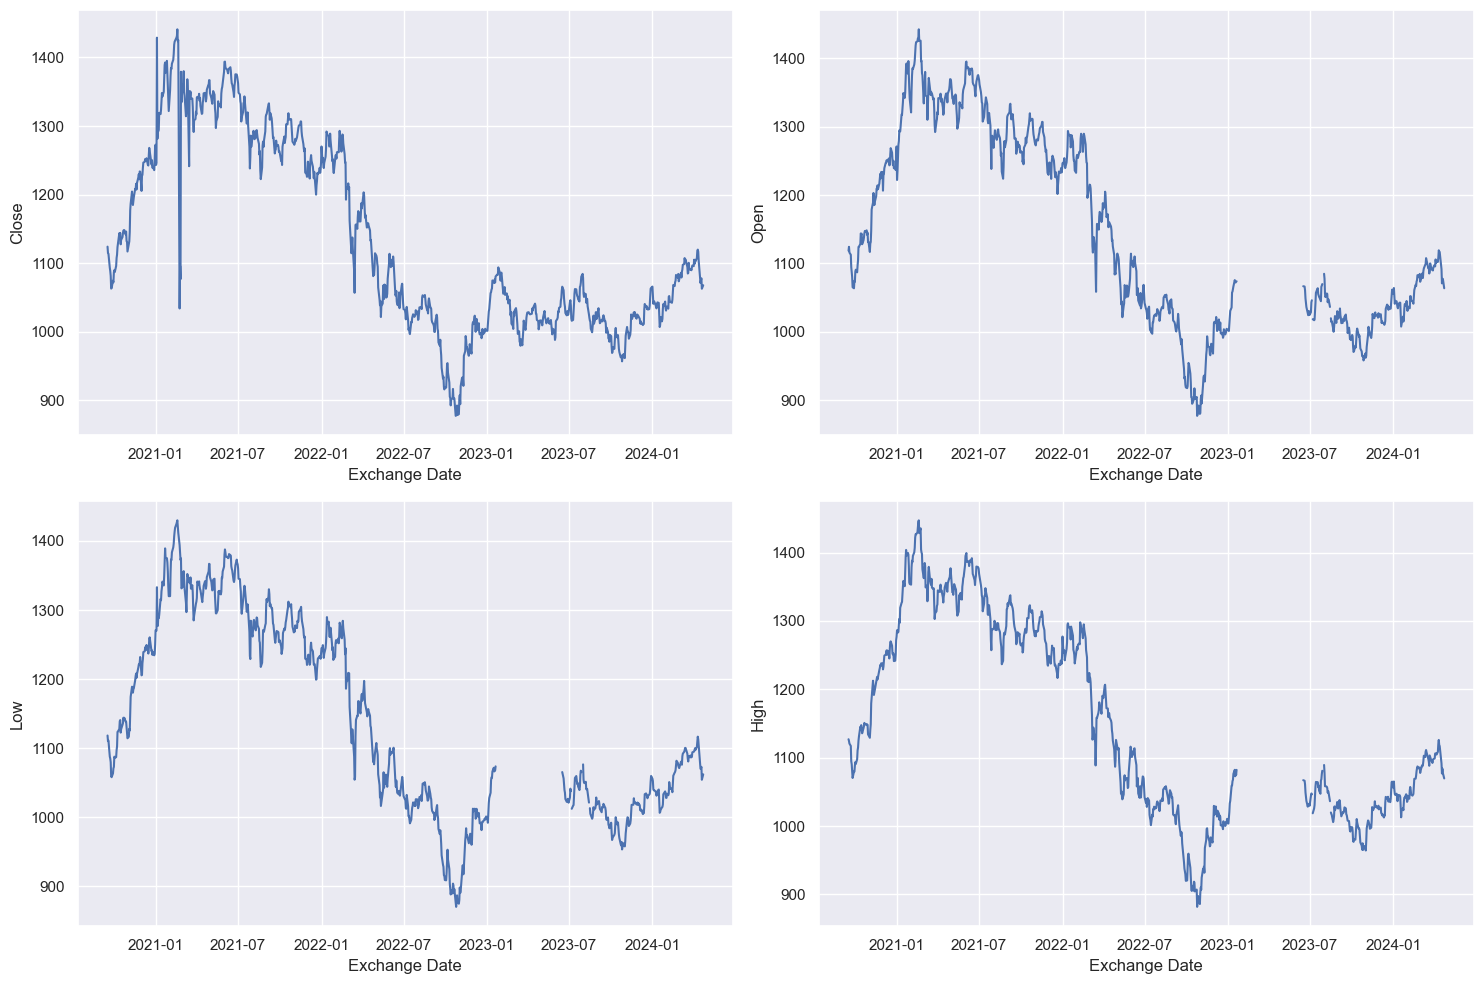

In [95]:
columns_to_plot = ['Close', 'Open', 'Low', 'High']
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.plot(df['Exchange Date'], df[column])
    plt.xlabel('Exchange Date')
    plt.ylabel(column)  
plt.tight_layout()  
plt.show()

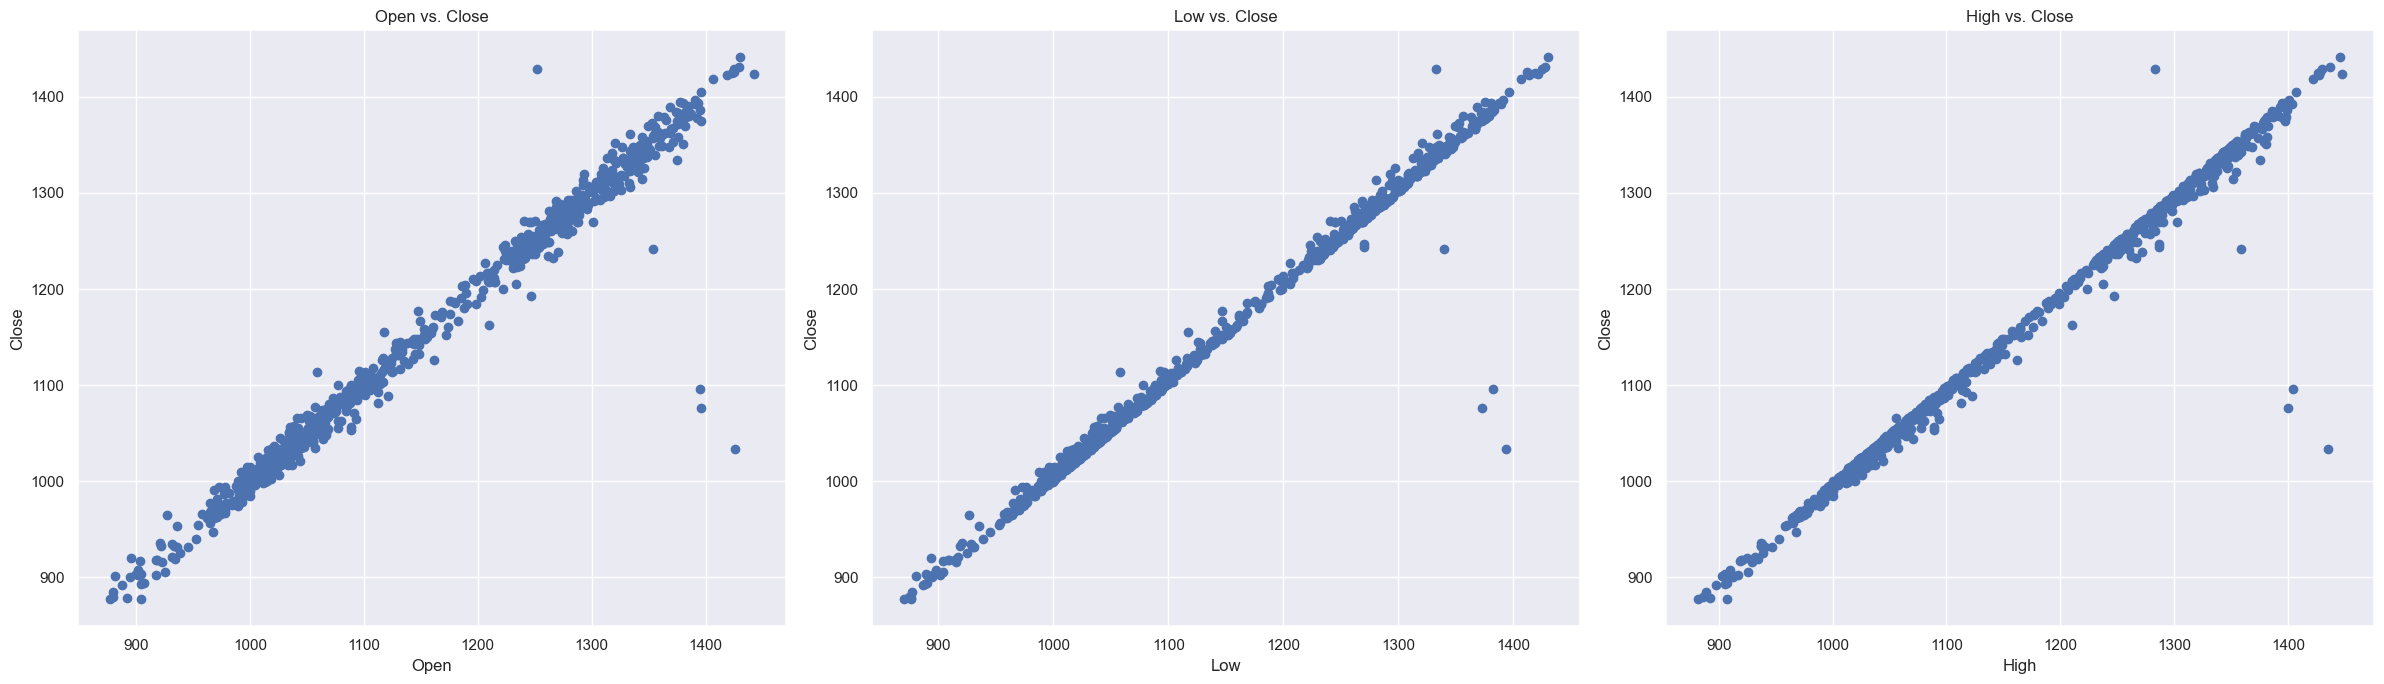

In [96]:
columns_to_plot = ['Open', 'Low', 'High']

# Create a figure and subplots using a for loop
fig, axes = plt.subplots(1, len(columns_to_plot), figsize=(24, 7))

for col, ax in zip(columns_to_plot, axes):
    ax.scatter(df[col], df['Close'])
    ax.set_xlabel(col)
    ax.set_ylabel('Close')
    ax.set_title(f'{col} vs. Close')

plt.tight_layout()
plt.show()

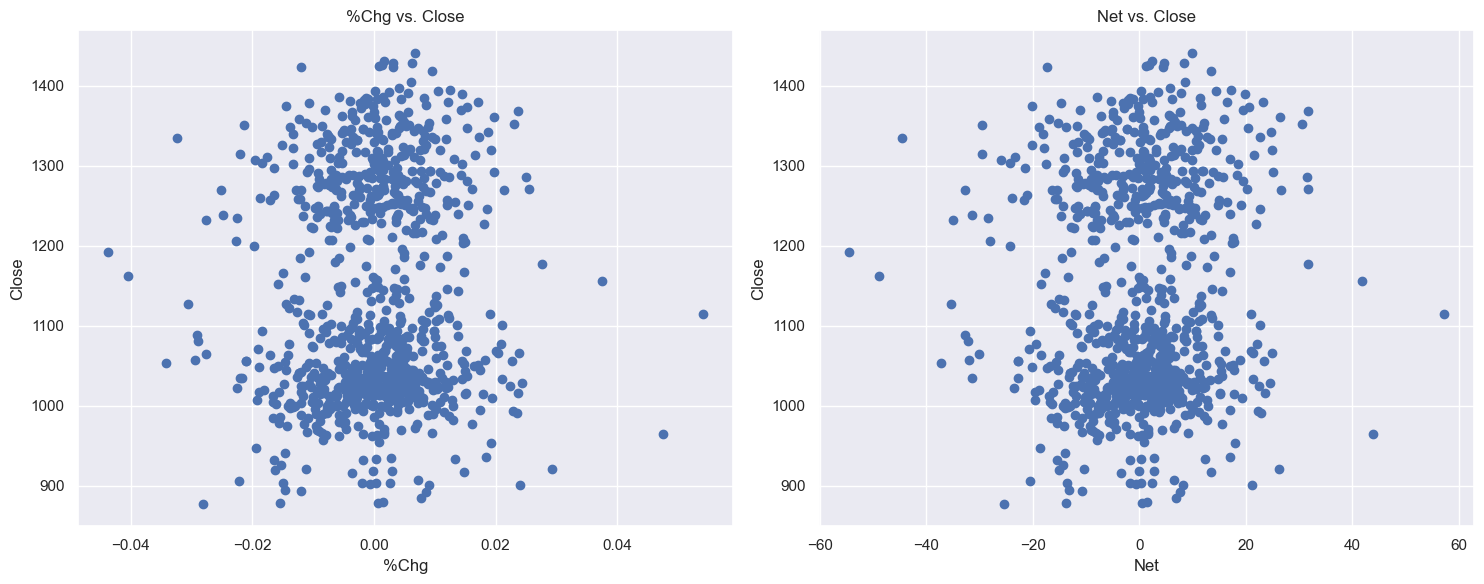

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.scatter(df['%Chg'], df['Close'])
ax1.set_xlabel('%Chg')
ax1.set_ylabel('Close')
ax1.set_title('%Chg vs. Close') 

ax2.scatter(df['Net'], df['Close'])
ax2.set_xlabel('Net')
ax2.set_ylabel('Close')
ax2.set_title('Net vs. Close') 

plt.tight_layout()
plt.show()

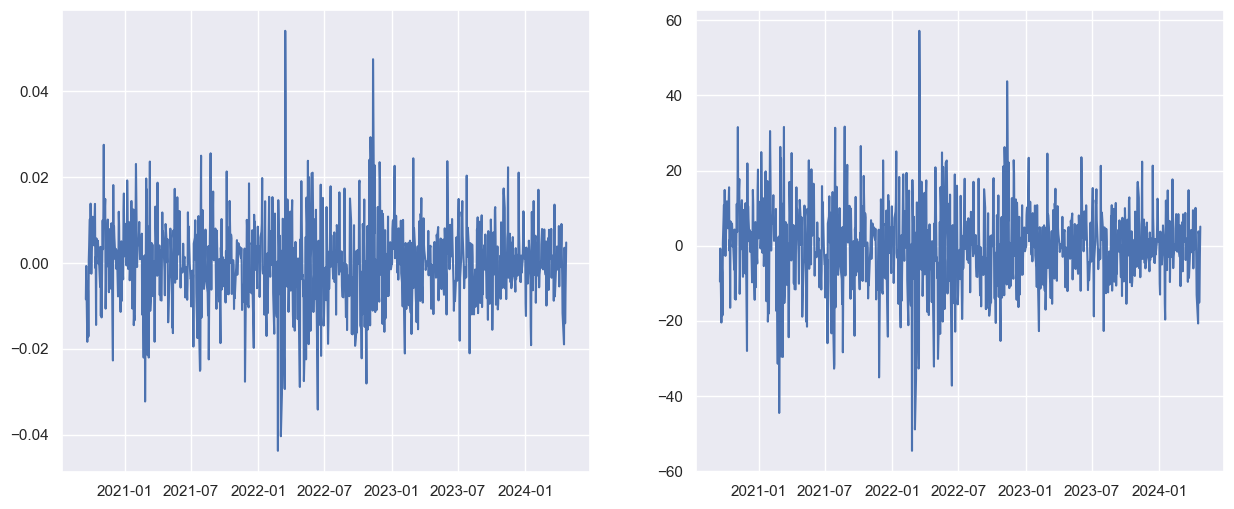

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(df['Exchange Date'], df['%Chg'])
ax2.plot(df['Exchange Date'], df['Net'])
plt.show()

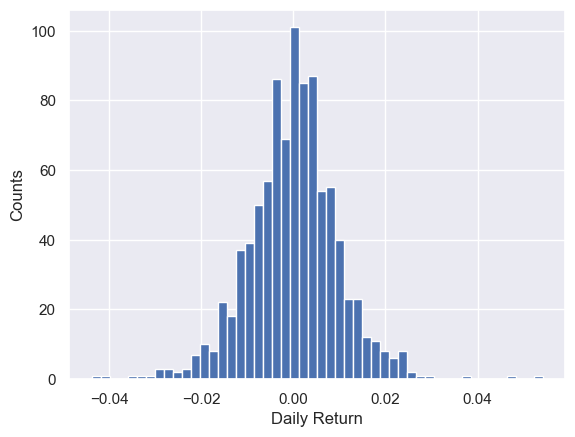

In [99]:
plt.hist(df['%Chg'], bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.show()

## Outliers

Visualizing the outliers:

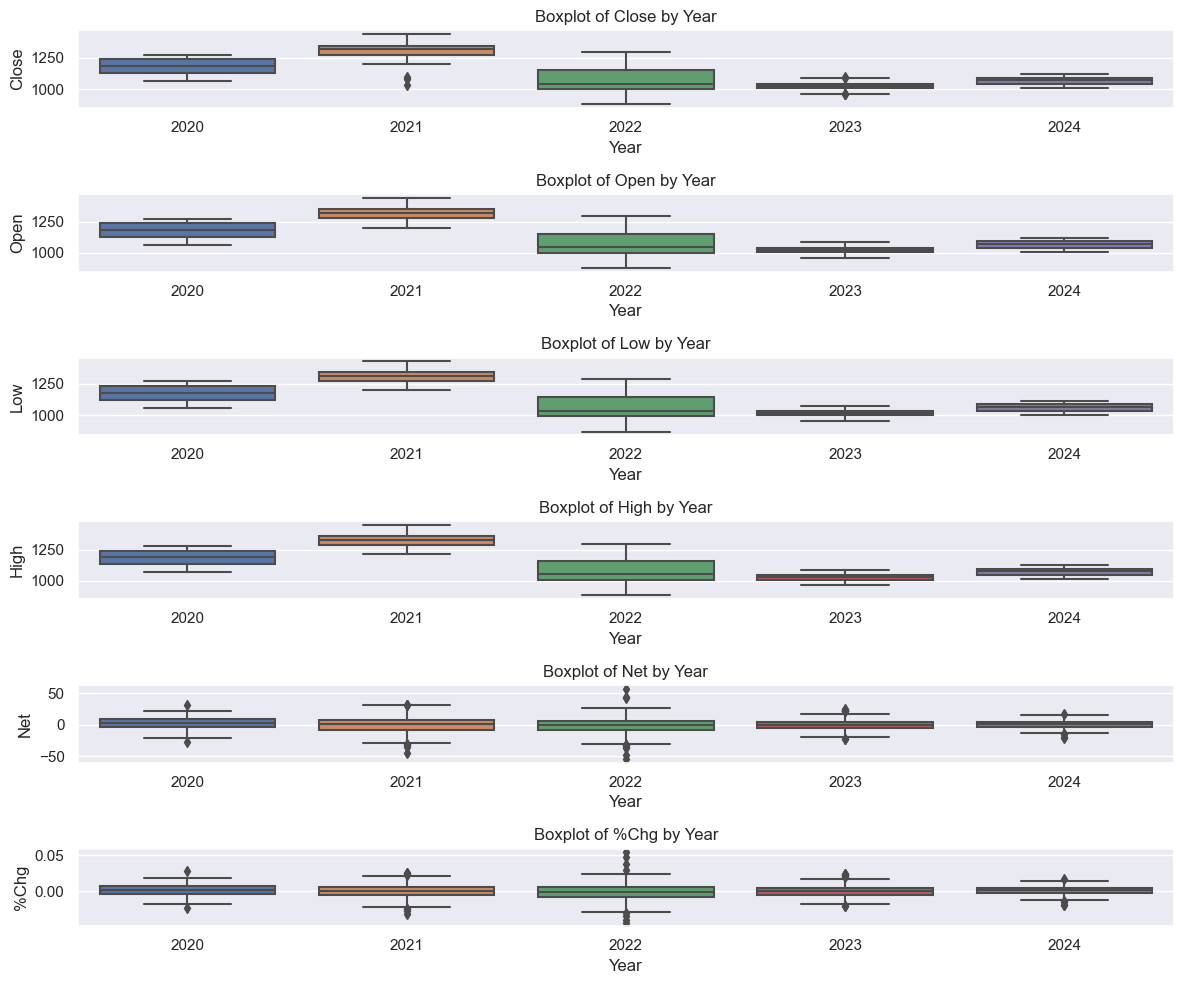

In [100]:
df['Year'] = df['Exchange Date'].dt.year
years = df['Year'].unique()
columns_to_plot = ['Close', 'Open', 'Low', 'High', 'Net', '%Chg']

fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(12, 10))

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    ax.set_title(f"Boxplot of {column} by Year")
    sns.boxplot(x="Year", y=column, data=df, ax=ax)

plt.tight_layout()
plt.show()

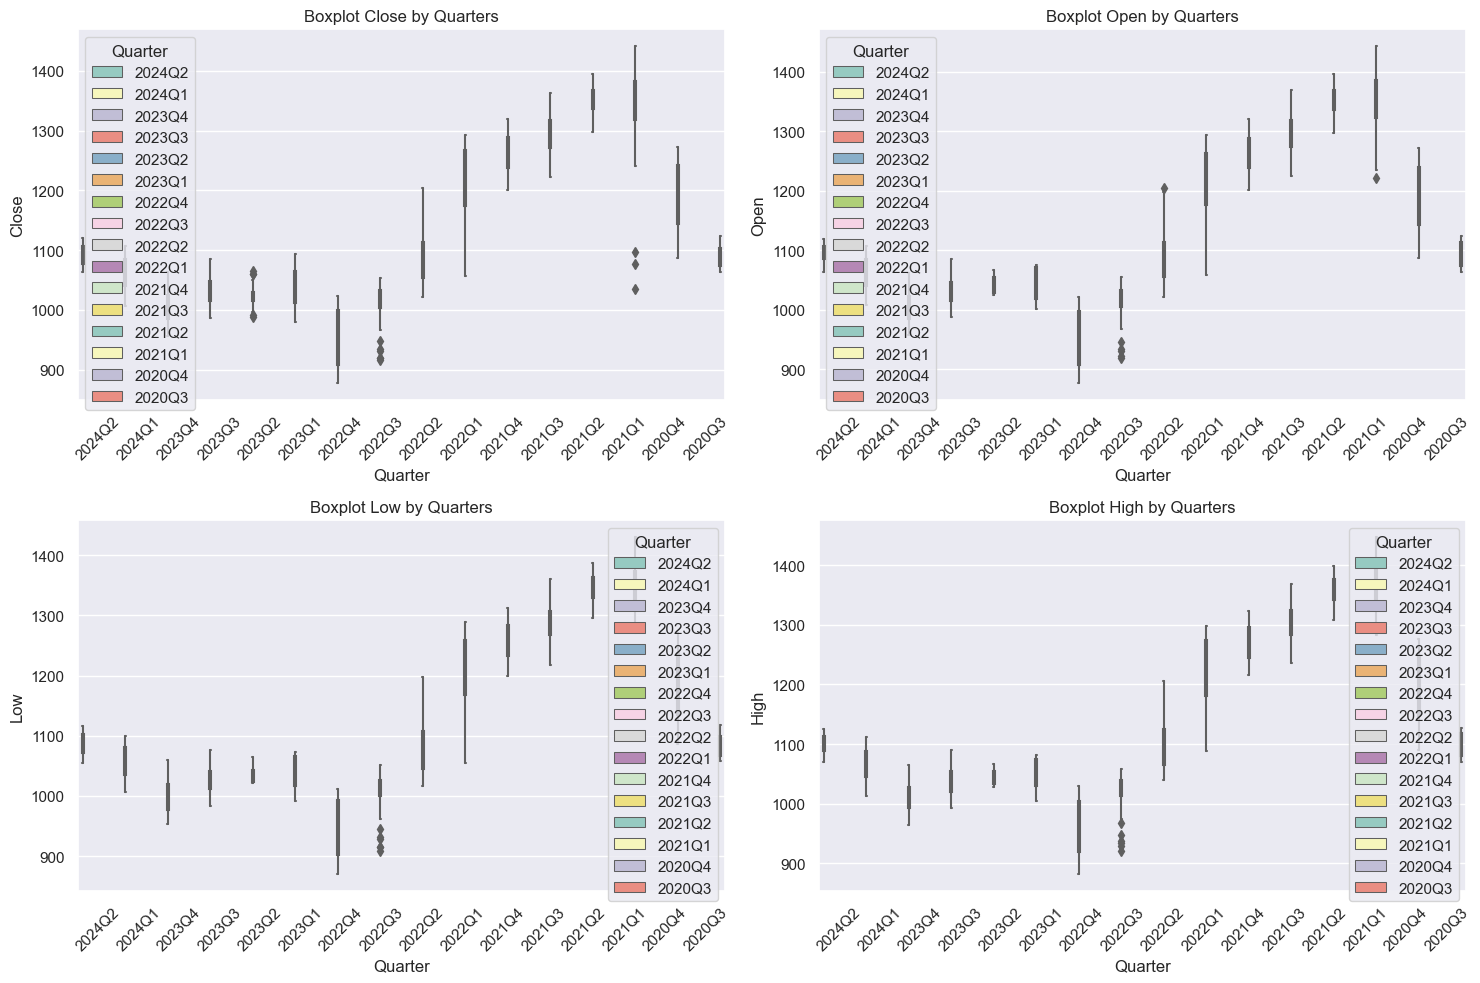

In [101]:
df['Quarter'] = df['Exchange Date'].dt.to_period('Q')
columns_to_plot = ['Close', 'Open', 'Low', 'High']
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='Quarter', y=column, data=df, palette='Set3', hue = 'Quarter')
    plt.title(f'Boxplot {column} by Quarters')
    plt.xlabel('Quarter')
    plt.ylabel(column)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Interquartile Range (IQR) method

In [102]:
df.set_index('Exchange Date', inplace=True)
print(df.head())

                 Close    Net      %Chg     Open      Low     High  Year  \
Exchange Date                                                              
2024-04-22     1067.81   5.08  0.004780  1063.63  1061.95  1069.61  2024   
2024-04-19     1062.73 -15.16 -0.014065  1077.39  1054.16  1077.51  2024   
2024-04-18     1077.89   3.02  0.002810  1076.24  1072.81  1083.88  2024   
2024-04-17     1074.87   3.81  0.003557  1070.80  1070.46  1076.86  2024   
2024-04-16     1071.06 -20.72 -0.018978  1091.60  1070.13  1091.64  2024   

              Quarter  
Exchange Date          
2024-04-22     2024Q2  
2024-04-19     2024Q2  
2024-04-18     2024Q2  
2024-04-17     2024Q2  
2024-04-16     2024Q2  


In [103]:
df = df.apply(pd.to_numeric, errors='coerce')

Q1 = df.quantile(0.25).astype(float)
Q3 = df.quantile(0.75).astype(float)
IQR = Q3 - Q1

outliers_mask = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
outliers = df[outliers_mask]
print(len(outliers))

37


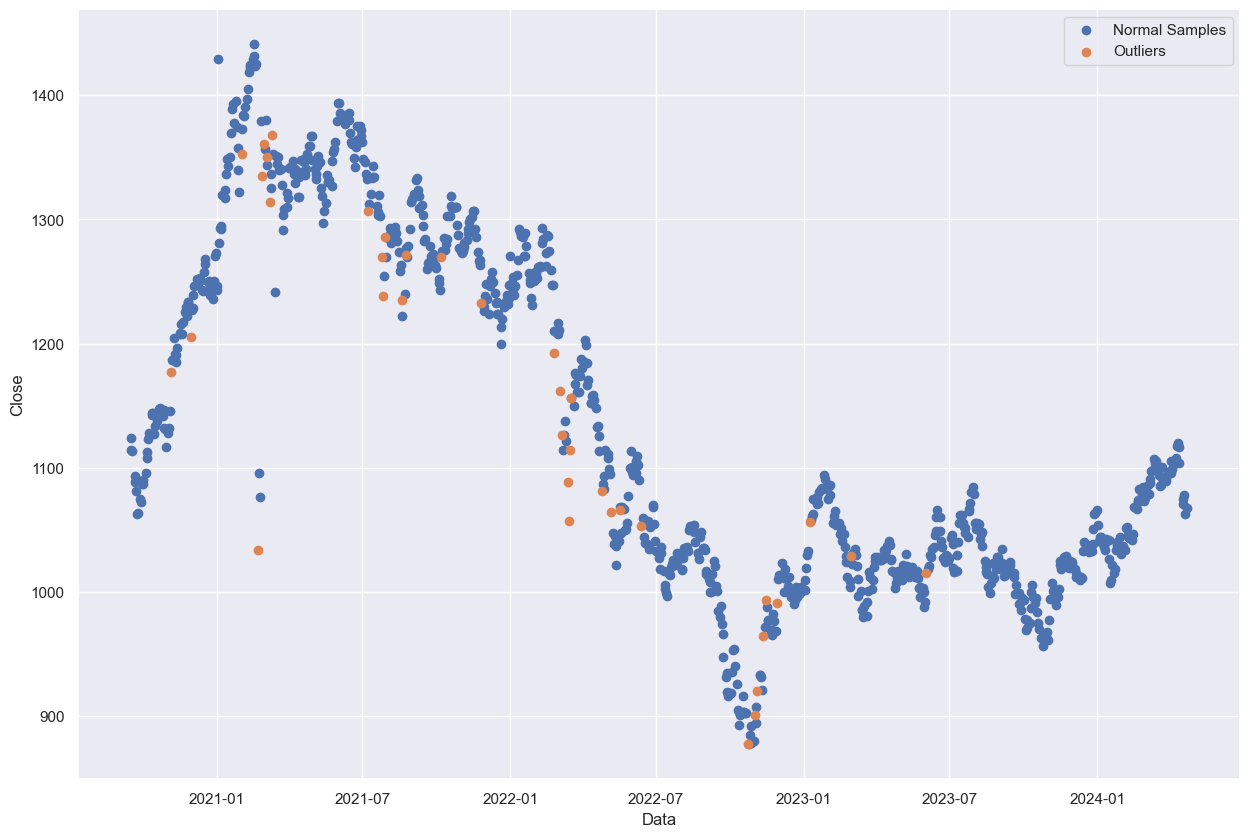

In [104]:
normal_df = df[~outliers_mask]
plt.figure(figsize=(15,10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
plt.xlabel("Data")
plt.ylabel("Close")
plt.legend()
plt.show()

## Robust z-score method (MAD - Median absolute deviation)

Not expected to perform well because the data is not normally distributed.

c:\Users\anaro\miniconda3\envs\lseg\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Close', ylabel='Density'>

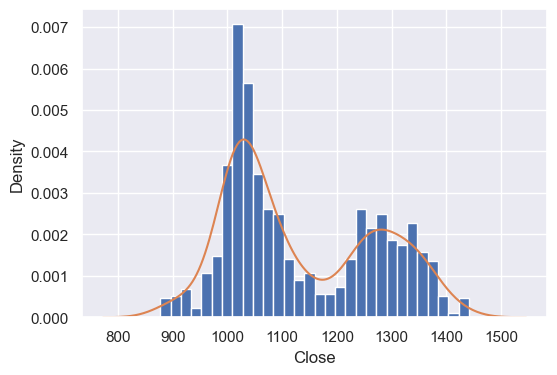

In [105]:
plt.figure(figsize=(6, 4))
plt.hist(df['Close'], bins=30, density=True)

sns.kdeplot(df['Close'])

Apply z-score for the entire dataset

In [106]:
from scipy.stats import median_abs_deviation
mad = median_abs_deviation(df['Close'])
median = np.median(df['Close'])
mean = np.mean(df['Close'])

def compute_robust_z_score(x):
  return 0.6745*(x - median)/mad

z_scores = df['Close'].apply(compute_robust_z_score)
lower_threshold = -1.5
upper_threshold = 2.5
outliers_mask = (z_scores < lower_threshold) | (z_scores > upper_threshold)
outliers = df[outliers_mask]

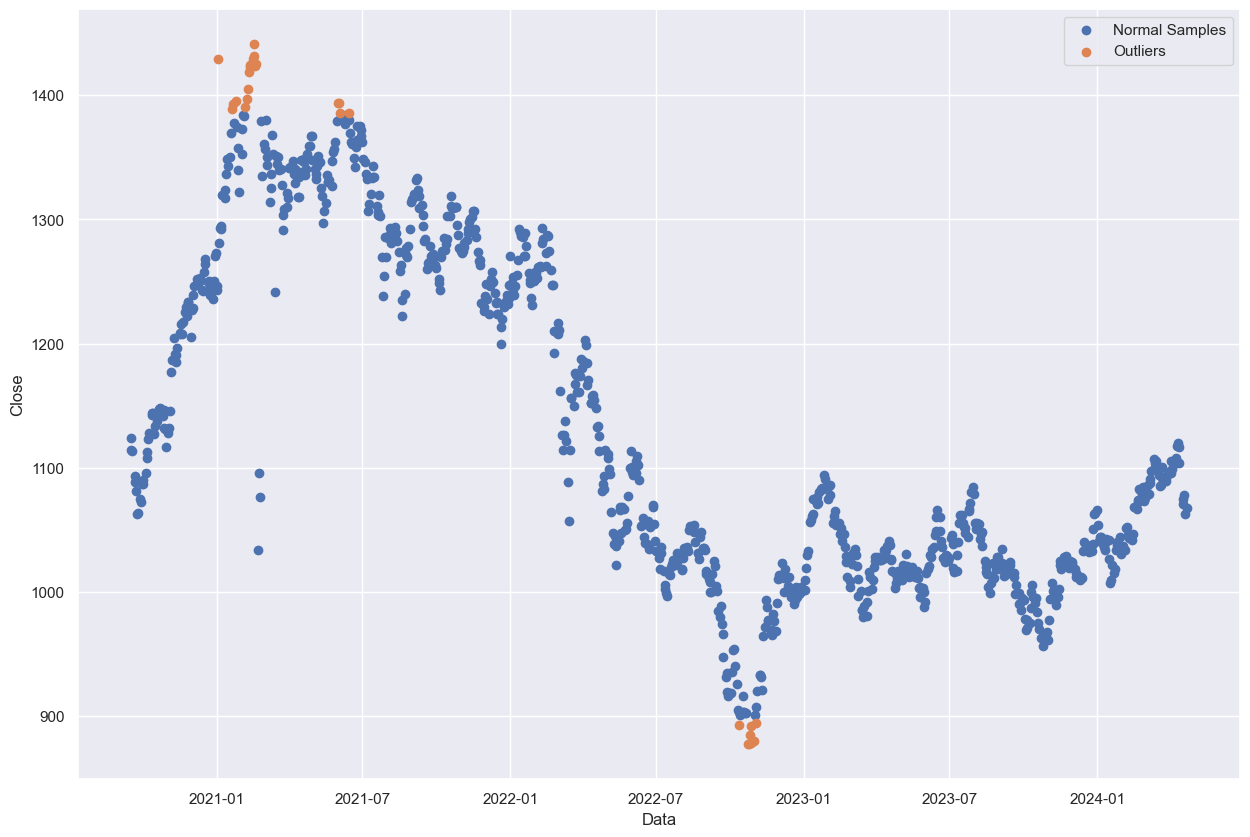

In [107]:
normal_df = df[~outliers_mask]
plt.figure(figsize=(15,10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
plt.xlabel("Data")
plt.ylabel("Close")
plt.legend()
plt.show()

Apply z-score for every month

In [108]:
df.index = pd.to_datetime(df.index)
df['Month'] = df.index.to_period('M')
grouped = df.groupby('Month')

outliers_list = []
normal_list = []

for month, data in grouped:
    mad = median_abs_deviation(data['Close'])
    median = np.median(data['Close'])
    
    z_scores = 0.6745 * (data['Close'] - median) / mad
    
    lower_threshold = -1.5
    upper_threshold = 2.5
    
    outliers_mask = (z_scores < lower_threshold) | (z_scores > upper_threshold)

    outliers_list.append(data[outliers_mask])
    normal_list.append(data[~outliers_mask])

outliers = pd.concat(outliers_list)
normal_df = pd.concat(normal_list)

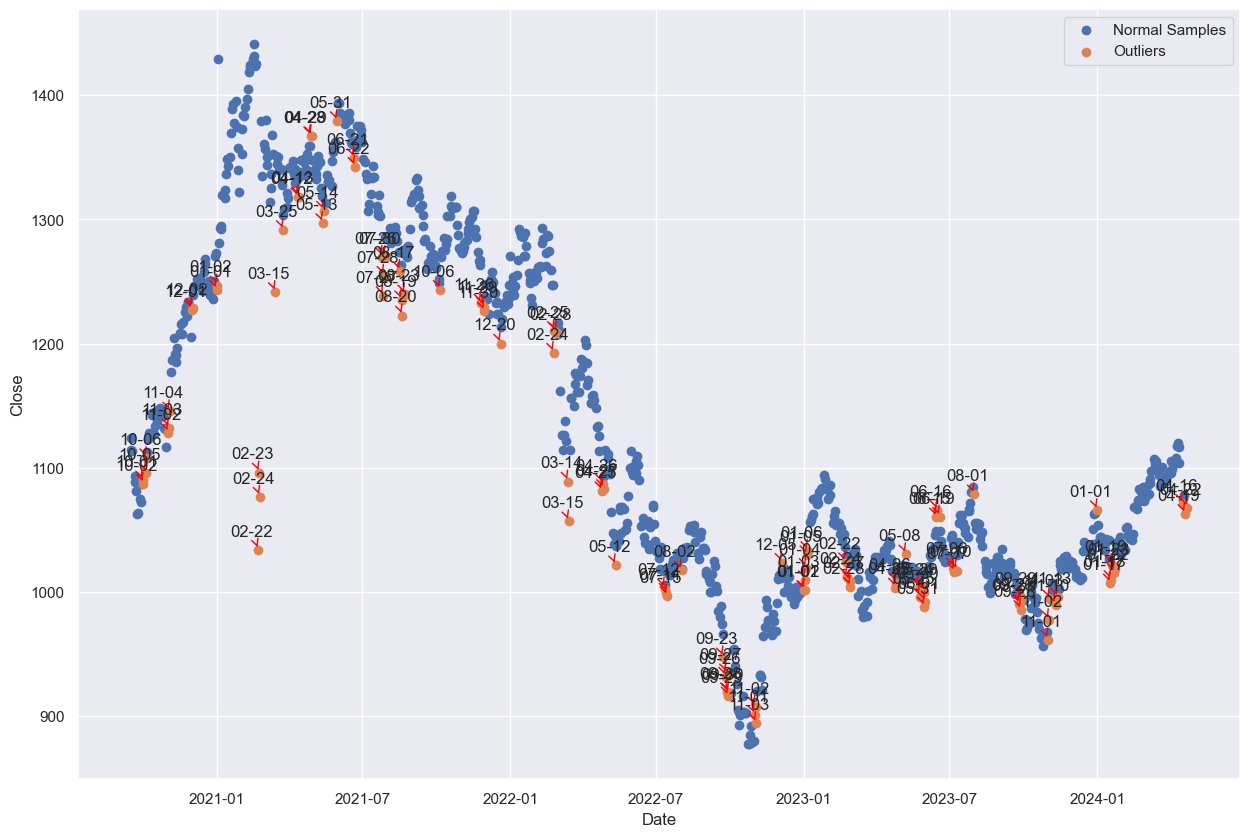

In [109]:
plt.figure(figsize=(15, 10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
for idx in outliers.index:
    plt.annotate(f"{idx.strftime('%m-%d')}", xy=(idx, outliers.loc[idx, 'Close']), xytext=(-20, 10),
                 textcoords='offset points', arrowprops=dict(arrowstyle='->', color='red'))

plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.show()

## Local Outlier Factor (LOF) method

In [110]:
df.head()
print(df.isna().sum())
df_relevant_columns = df[['Close']]
df_relevant_columns.head()

Close        0
Net          1
%Chg         1
Open       107
Low        107
High       107
Year         0
Quarter    940
Month        0
dtype: int64


,Close
Exchange Date,
2024-04-22,1067.81
2024-04-19,1062.73
2024-04-18,1077.89
2024-04-17,1074.87
2024-04-16,1071.06


In [111]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1) # default values, play with them
y_pred = lof.fit_predict(df_relevant_columns)
scores = lof.negative_outlier_factor_
print("Number of outliers detected: {}".format(np.sum(y_pred == -1)))
print("Number of normal samples detected: {}".format(np.sum(y_pred == 1)))

Number of outliers detected: 94
Number of normal samples detected: 846


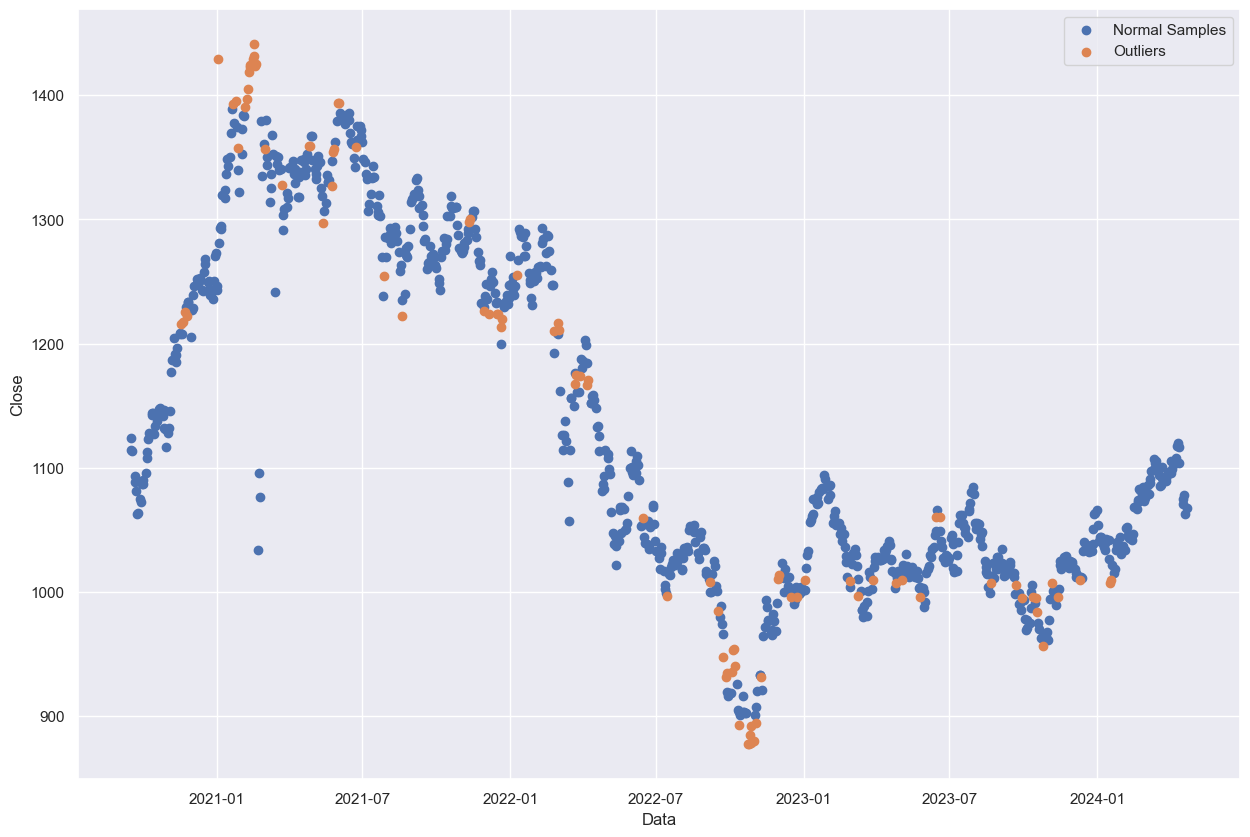

In [112]:
normal_df = df_relevant_columns[y_pred > 0]
outliers = df_relevant_columns[y_pred < 0]
plt.figure(figsize=(15,10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
plt.xlabel("Data")
plt.ylabel("Close")
plt.legend()
plt.show()

Nu inteleg de ce aici nu detecteaza punctele din 2021-02 ca fiind outliers ptc densitatea vecinilor lor e scazuta => izolate => outliers.

## Isolation Forest

to do: sa detectez pe ani/trimestre, nu pe intreg setul de date, desi nu stiu daca merita, are rezultate similare cu MAD, pare ca nu se preteaza cu distributia datelor noastre

In [113]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators = 100, contamination = 0.03, max_samples = 'auto')
y_pred = iforest.fit_predict(df_relevant_columns.values)
print("Number of outliers detected: {}".format(np.sum(y_pred == -1)))
print("Number of normal samples detected: {}".format(y_pred[y_pred > 0].sum()))

Number of outliers detected: 29
Number of normal samples detected: 911


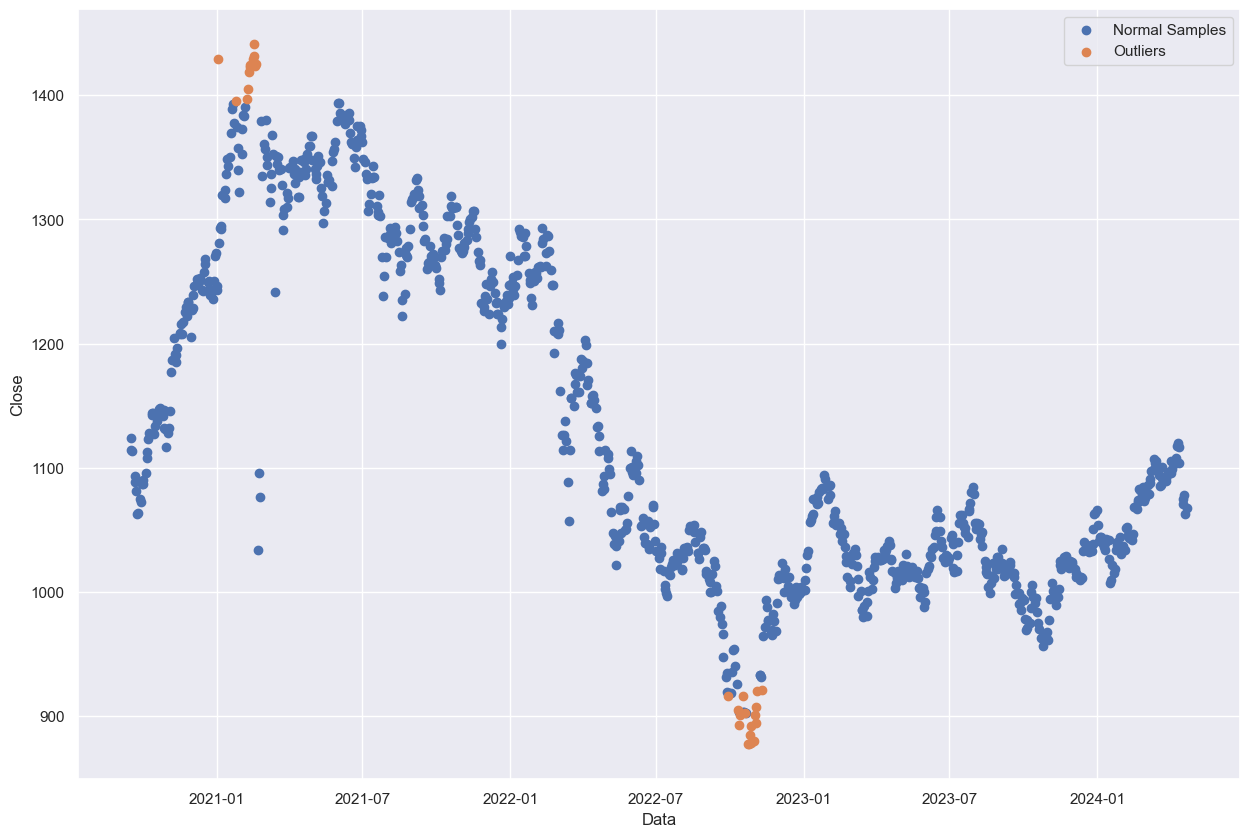

In [114]:
normal_df = df_relevant_columns[y_pred > 0]
outliers = df_relevant_columns[y_pred < 0]
plt.figure(figsize=(15,10))
plt.scatter(normal_df.index, normal_df['Close'], label="Normal Samples")
plt.scatter(outliers.index, outliers['Close'], label="Outliers")
plt.xlabel("Data")
plt.ylabel("Close")
plt.legend()
plt.show()

Mai sunt si Mahalanobis distance, PCA methods..
to do: ACF, PACF plots

### Remove redundant columns after EDA
Asta rezolva si eroarea de la correlation matrix: 'Month' avea tip de 'Period'

In [115]:
df.reset_index(inplace=True)
df.drop(columns=['Year', 'Quarter', 'Month'], inplace=True)

In [116]:
df.columns

Index(['Exchange Date', 'Close', 'Net', '%Chg', 'Open', 'Low', 'High'], dtype='object')

## Corelation matrix

c:\Users\anaro\miniconda3\envs\lseg\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


,Exchange Date,Close,Net,%Chg,Open,Low,High
Exchange Date,1.000000,-0.747079,-0.014333,-0.012067,-0.733376,-0.731095,-0.738291
Close,-0.747079,1.000000,0.057873,0.054537,0.984914,0.988776,0.987114
Net,-0.014333,0.057873,1.000000,0.992462,-0.035806,0.011220,0.004282
%Chg,-0.012067,0.054537,0.992462,1.000000,-0.036541,0.009363,0.003908
Open,-0.733376,0.984914,-0.035806,-0.036541,1.000000,0.998146,0.998621
Low,-0.731095,0.988776,0.011220,0.009363,0.998146,1.000000,0.998551
High,-0.738291,0.987114,0.004282,0.003908,0.998621,0.998551,1.000000


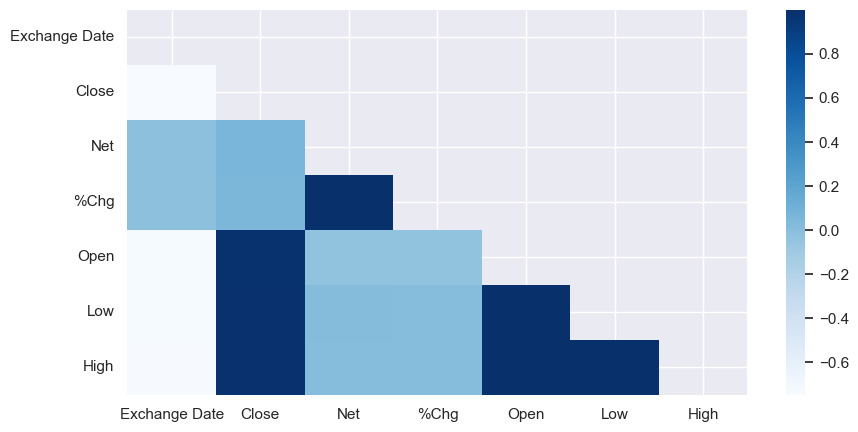

In [117]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,5))
sns.heatmap(corr, cmap="Blues", annot=True, mask = mask)
corr

# Missing Values

In [118]:
# linear interpolation
df_linear_interpolation = df.copy(deep=True)
df_linear_interpolation['Open'] = df_linear_interpolation['Open'].interpolate(method='linear')

# polynomail interpolation
df_polynomial_interpolation = df.copy(deep=True)
df_polynomial_interpolation['Open'] = df_polynomial_interpolation['Open'].interpolate(method='polynomial', order=2)

# pad interpolation
df_pad_interpolation = df.copy(deep=True)
df_pad_interpolation['Open'] = df_pad_interpolation['Open'].ffill()

## Cubic Spline

<div style="color: #ff365e; font-weight: bold;">
    WARNING
</div>

Din nu stiu ce cauza, la cubic spline daca nu rulezi si graficele plotate de Ana mai inainte, mereu o sa aiba anomalia aia unde se strica varful de la 2023-07 cu 1100

In [119]:
from scipy.interpolate import CubicSpline
df_cublicSpline = df.copy(deep=True)

# Extracting non-missing values
x = df['Exchange Date'][df['Open'].notnull()][::-1]
y = df['Open'].dropna()[::-1]

# Perform cubic spline interpolation
cs = CubicSpline(x, y)
interpolated_values = cs(df['Exchange Date'])
# indices of missing values that were filled 
filled_indices = df['Open'].isnull()

# noise function to add on top of interpolation
noise_level = 5
noise = np.random.normal(scale=noise_level, size=len(df_cublicSpline['Open']))
# convoluting with a gaussian distribution to smooth out the noise
smooth_noise = np.convolve(noise, np.ones(20)/2, mode='same')

# adding the noise to the interpolation
interpolated_values[filled_indices] += smooth_noise[filled_indices]

df_cublicSpline['Open'] = interpolated_values

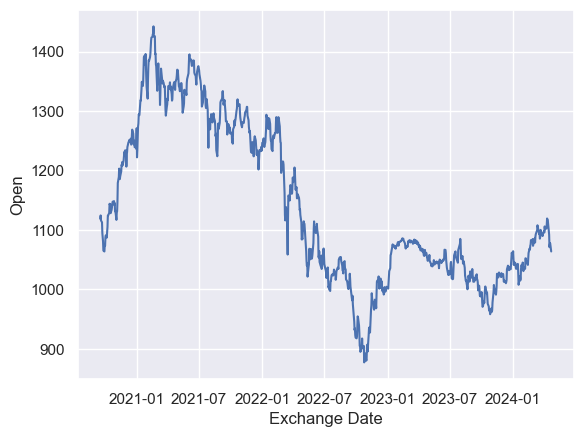

In [120]:
plt.plot(df_cublicSpline['Exchange Date'], df_cublicSpline['Open'])
plt.xlabel('Exchange Date')
plt.ylabel('Open')
plt.show()

## All Interpolations

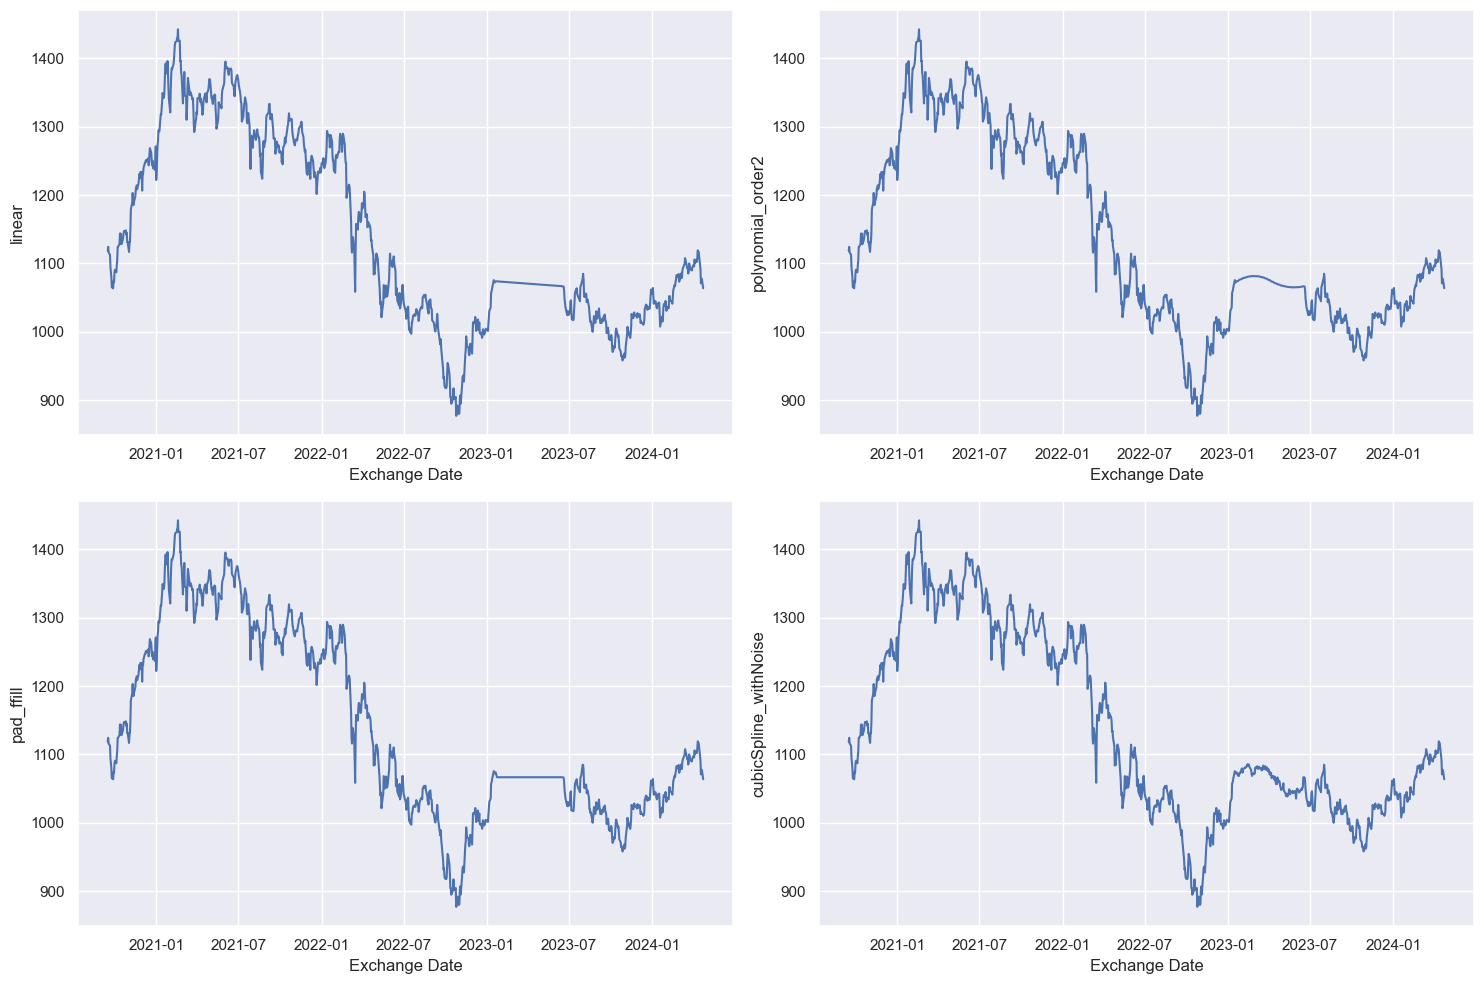

In [121]:
df_interpolations = df.copy(deep=True)

interpolations = [
    ("linear", df_linear_interpolation['Open'].interpolate(method='linear')),
    ("polynomial_order2", df_polynomial_interpolation['Open'].interpolate(method='polynomial', order=2)),
    ("pad_ffill", df_pad_interpolation['Open'].ffill()),
    ("cubicSpline_withNoise", df_cublicSpline['Open'])
]

plt.figure(figsize=(15, 10))
for i, interpolation in enumerate(interpolations, 1):
    plt.subplot(2, 2, i)
    df_interpolations[interpolation[0]] = interpolation[1]
    plt.plot(df_interpolations['Exchange Date'], df_interpolations[interpolation[0]])
    plt.xlabel('Exchange Date')
    plt.ylabel(interpolation[0])
plt.tight_layout()
plt.show()

## Data Cleaning

### Dupplicate value with different date

In [122]:
columns = ["Exchange Date", "Close", "Net", "%Chg", "Open", "Low", "High"]
duplicate_rows = df[df.duplicated(subset=columns[1:], keep=False)]
duplicate_rows

,Exchange Date,Close,Net,%Chg,Open,Low,High
337,2023-01-02,1001.45,-0.2,-0.0002,1002.88,1000.17,1003.67
338,2023-01-01,1001.45,-0.2,-0.0002,1002.88,1000.17,1003.67


In [123]:
from datetime import datetime

for date in duplicate_rows['Exchange Date']:
    date_timestamp = pd.Timestamp(date)

    weekday_name = date_timestamp.day_name()

    print("The weekday of", date, "is:", weekday_name)

The weekday of 2023-01-02 00:00:00 is: Monday
The weekday of 2023-01-01 00:00:00 is: Sunday


In [124]:
df.drop(index=338, inplace=True)

### Matrix for Differences

In [125]:
difference_matrix = []

for i in range(len(df)):
    try:
        row1 = df.loc[i, columns].values
        row2_diff = (df.loc[:, columns] == row1).sum(axis=1)
        difference_matrix.append(row2_diff)
    except:
        difference_matrix.append(0)
        
# print(difference_matrix)

In [126]:
indices_of_common_rows = []

for i, row in enumerate(difference_matrix):
    if i in [34, 35, 94, 93, 338]:
        continue

    for j in range(len(row)):
        if j in [34, 35, 94, 93, 338]:
            continue

        if i != j and row[j] != 0:
            indices_of_common_rows.append((i, j, row[j]))

# print(indices_of_common_rows)

In [127]:
filtered_indices = [ind for ind in indices_of_common_rows if ind[2] != 1 and ind[0] < ind[1]]
print(filtered_indices)

[(103, 104, 3), (861, 862, 2)]


In [128]:
rows_to_print = [103, 104, 860, 861]
print(df.iloc[rows_to_print].to_string(index=False))

Exchange Date   Close   Net      %Chg    Open     Low    High
   2023-11-24 1022.54 -6.04 -0.005872 1023.77 1021.38 1029.32
   2023-11-23 1028.58  4.86  0.004747 1023.77 1021.38 1029.32
   2021-01-02 1246.68  8.57  0.006400 1234.00 1270.08 1286.31
   2021-01-01 1243.26  9.60  0.006500 1222.00 1270.08 1286.31


Even though they have similar values, we see they are in range and we can't validate them through an API (only a datapoint for close value per week is available)

### Checking weekend days

In [129]:
df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])

rows_with_weekend_dates = df[(df['Exchange Date'].dt.dayofweek == 6) | (df['Exchange Date'].dt.dayofweek == 5)]
if not rows_with_weekend_dates.empty:
    print("Rows with Exchange Date equal to Saturday or Sunday:")
    print(rows_with_weekend_dates)
else:
    print("There are no rows with Exchange Date equal to Saturday or Sunday.")

Rows with Exchange Date equal to Saturday or Sunday:
    Exchange Date    Close   Net    %Chg    Open      Low     High
599    2022-01-01  1270.15  1.83  0.0016  1246.5  1244.77  1277.12
860    2021-01-03  1428.80  8.34  0.0062  1252.0  1333.00  1283.00
861    2021-01-02  1246.68  8.57  0.0064  1234.0  1270.08  1286.31


In [130]:
df = df.drop([599, 860, 861])

In [131]:
print(df.shape)


(936, 7)


### Check for missing days and add them

In [132]:
# the dataset starts from 2024-04-22 (Monday) - position 0 in the dataset
# we start checking from 2020-09-19 (Friday) - position 1 in the dataset if we miss any trading days

i = 1
while i + 4 < len(df) - 1:
    current_date = df.iloc[i]['Exchange Date']
    next_date = df.iloc[i + 4]['Exchange Date']

    if current_date.dayofweek != 4: # friday
        print(f"A date is missing between {current_date} and {next_date}")
        while current_date.dayofweek != 4:
            i += 1
            current_date = df.iloc[i]['Exchange Date']
        next_date = df.iloc[i + 4]['Exchange Date']
    
    if next_date.dayofweek == 0: # monday
        i += 5
    else:
        print(f"A date is missing between {current_date} and {next_date}")
        i += next_date.dayofweek

A date is missing between 2024-04-19 00:00:00 and 2024-04-12 00:00:00
A date is missing between 2024-03-14 00:00:00 and 2024-03-08 00:00:00
A date is missing between 2024-02-16 00:00:00 and 2024-02-09 00:00:00


We observe, alongside the xlsx file, that the missing days are:

2024-04-15

2024-03-15

2024-02-15

We fetch them manually from the charts since there is no full data provided by API.

In [133]:
# print(df[df['Exchange Date'] == '2024-04-12']) -> row 5
def insert_row(idx, df, df_insert):
    df_insert['Exchange Date'] = pd.to_datetime(df_insert['Exchange Date'])

    dfA = df.iloc[:idx, ]
    dfB = df.iloc[idx:, ]

    df = pd.concat([dfA, df_insert, dfB]).reset_index(drop=True)

    return df

new_row = pd.DataFrame({'Exchange Date': ['2024-04-15'], 'Open': [1104.45], 'High': [1104.45], 'Low': [1091.27], 'Close': [1091.78], 'Net': [-11.83], '%Chg': [-1.071937]})
df = insert_row(5, df, new_row)

In [134]:
print(df.iloc[4:7])

  Exchange Date    Close    Net      %Chg     Open      Low     High
4    2024-04-16  1071.06 -20.72 -0.018978  1091.60  1070.13  1091.64
5    2024-04-15  1091.78 -11.83 -1.071937  1104.45  1091.27  1104.45
6    2024-04-12  1103.61 -13.09 -0.011722  1116.74  1103.61  1117.06


In [135]:
# print(df[df['Exchange Date'] == '2024-03-14']) -> -> row 26
new_row = pd.DataFrame({'Exchange Date': ['2024-03-15'], 'Open': [1097.95], 'High': [1097.95], 'Low': [1091.02], 'Close': [1092.73], 'Net': [-12.73], '%Chg': [-1.15155682]})
df = insert_row(26, df, new_row)

In [136]:
print(df.iloc[25:28])

   Exchange Date    Close    Net      %Chg     Open      Low     High
25    2024-03-18  1094.58   1.85  0.001693  1092.81  1091.85  1097.84
26    2024-03-15  1092.73 -12.73 -1.151557  1097.95  1091.02  1097.95
27    2024-03-14  1105.46   1.87  0.001694  1104.64  1100.26  1107.94


In [137]:
# print(df[df['Exchange Date'] == '2024-02-14']) -> row 47
new_row = pd.DataFrame({'Exchange Date': ['2024-02-15'], 'Open': [1054.09], 'High': [1060.84], 'Low': [1054.09], 'Close': [1059.81], 'Net': [13.06], '%Chg': [1.24767136]})
df = insert_row(47, df, new_row)

In [138]:
print(df.iloc[46:49])

   Exchange Date    Close    Net      %Chg     Open      Low     High
46    2024-02-16  1068.22   8.41  0.007935  1060.94  1059.97  1069.00
47    2024-02-15  1059.81  13.06  1.247671  1054.09  1054.09  1060.84
48    2024-02-14  1046.75   4.52  0.004337  1041.04  1036.13  1046.90


### Checking the obvious outliers from the charts

In [139]:
outliers_2021 = ["2021-02-22", "2021-02-23", "2021-02-24", "2021-03-15", "2021-03-25", "2021-05-18"]
values = pd.to_datetime(outliers_2021)

filtered_df = df[df['Exchange Date'].isin(values)]
filtered_df

,Exchange Date,Close,Net,%Chg,Open,Low,High
764,2021-05-18,1336.05,22.72,0.017300,1313.06,1312.53,1337.51
802,2021-03-25,1291.32,-11.99,-0.009200,1302.23,1284.95,1302.75
810,2021-03-15,1241.41,-8.26,-0.006106,1353.76,1339.93,1358.50
823,2021-02-24,1076.70,-19.43,-0.013917,1396.44,1372.46,1400.09
824,2021-02-23,1096.13,2.14,0.001535,1395.51,1382.19,1404.35
825,2021-02-22,1033.99,-31.45,-0.022063,1425.80,1393.95,1435.36


We observe that rows 810, 823, 824, 825 consist values for open and close which are out of range [low, high].

In [140]:
out_of_range = [825, 824, 823, 810]

with pd.option_context("mode.copy_on_write", True):
    for row_index in out_of_range:
        if row_index < len(df) - 1:
            next_close = df.loc[row_index + 1, 'Close']
            current_net = round(df.loc[row_index, 'Net'], 2)
        
            df.loc[row_index, 'Close'] = next_close + current_net

In [141]:
changed_rows = df[df.index.isin(out_of_range)]
print(changed_rows)

    Exchange Date    Close    Net      %Chg     Open      Low     High
810    2021-03-15  1344.61  -8.26 -0.006106  1353.76  1339.93  1358.50
823    2021-02-24  1376.70 -19.43 -0.013917  1396.44  1372.46  1400.09
824    2021-02-23  1396.13   2.14  0.001535  1395.51  1382.19  1404.35
825    2021-02-22  1393.99 -31.45 -0.022063  1425.80  1393.95  1435.36


### Checking NET values 

In [142]:
errors = []
for i in range(1, len(df)):
    if df.iloc[i-1]['Close'] - df.iloc[i-1]['Net'] != df.iloc[i]['Close']:
        errors.append((i - 1, i))
        
print(f"Numar errori la NET: {len(errors)}")

Numar errori la NET: 4


In [143]:
with pd.option_context("mode.copy_on_write", True):
    for error in errors:
        row1 = error[0]
        row2 = error[1]

        df.at[row1, 'Net'] = round(-(df.at[row2, 'Close'] - df.at[row1, 'Close']), 2)
        df.at[row1, '%Chg'] = (df.at[row1, 'Net'] / df.at[row2, 'Close']) * 100

rows = []
for error in errors:
    rows.append(error[0])
    rows.append(error[1])
changed_rows = df[df.index.isin(rows)]
print(changed_rows)

    Exchange Date    Close    Net      %Chg     Open      Low     High
79     2024-01-02  1053.79 -12.06 -1.131491  1063.99  1052.33  1065.07
80     2024-01-01  1065.85   1.97  0.185171  1055.57  1055.65  1055.84
81     2023-12-29  1063.88   1.14  0.001073  1061.57  1059.65  1064.84
860    2021-01-04  1281.32  38.06  3.061307  1273.54  1277.00  1284.00
861    2021-01-01  1243.26 -29.46 -2.314728  1222.00  1270.08  1286.31
862    2020-12-31  1272.72   1.97  0.001550  1271.02  1270.65  1276.95


### Checking %CHG values

In [144]:
chg_errors = []
epsilon = 0.015

for i in range(1, len(df)):
    percentage = (df.iloc[i-1]['Close'] - df.iloc[i]['Close']) / df.iloc[i-1]['Close']
    
    if not (df.iloc[i - 1]['%Chg'] - epsilon <= percentage <= df.iloc[i - 1]['%Chg'] + epsilon):
        chg_errors.append((df.iloc[i-1], df.iloc[i]))

print(f"Numar errori la %CHG: {len(chg_errors)}")
# for error in chg_errors:
#     print(*error, sep="\n", end="\n\n")

Numar errori la %CHG: 7


We ignore %CHG since we drop this feature by being 100% correlated to NET.

### An alternative to cubic spline interpolation for 2023 missing values
We saw on the real graph from tradingview that this is similar to the graph of close values. On the interpolated open value, we have some misleading ups and downs, so we decided to have a formula such as:

open_current = open_previous + (close_previous - close_current)



In [145]:
def fill_missing_open(start_row, end_row):
    for row in range(start_row, end_row, -1):
        df.at[row, 'Open'] = df.at[row + 1, 'Open'] + df.at[row, 'Net']
        df.at[row, 'High'] = max(df.at[row, 'Open'], df.at[row, 'Close'])
        df.at[row, 'Low'] = min(df.at[row, 'Open'], df.at[row, 'Close'])

start_date = "2023-01-23"
end_date   = "2023-06-15"

start_row   = df.index[df['Exchange Date'] == start_date].item()
end_row = df.index[df['Exchange Date'] == end_date].item() - 1

fill_missing_open(start_row, end_row)

In [146]:
# We have missing open values for 3 more days

day1 = df.index[df['Exchange Date'] == "2023-07-06"].item()
day2 = df.index[df['Exchange Date'] == "2023-07-31"].item()
day3 = df.index[df['Exchange Date'] == "2023-08-15"].item()

fill_missing_open(day1, day1 - 1)
fill_missing_open(day2, day2 - 1)
fill_missing_open(day3, day3 - 1)

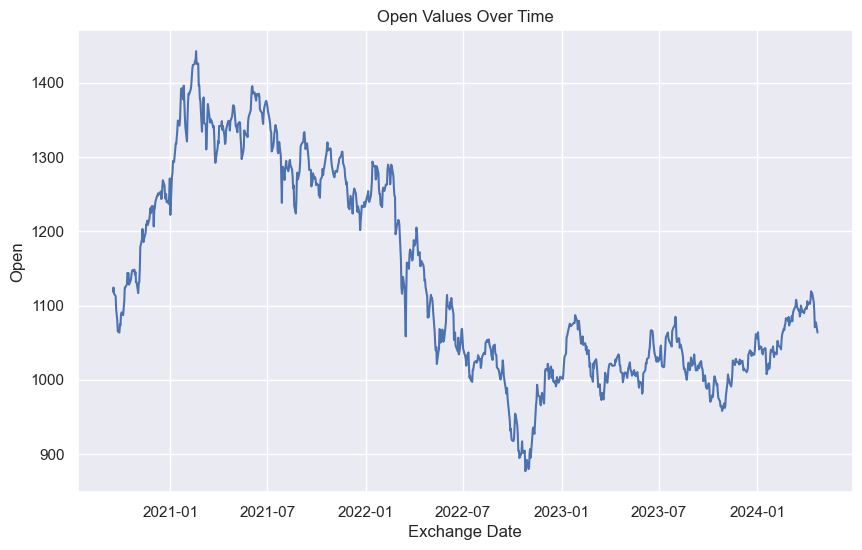

In [147]:
plt.figure(figsize=(10, 6))
plt.plot(df['Exchange Date'], df['Open'])
plt.xlabel('Exchange Date')
plt.ylabel('Open')
plt.title('Open Values Over Time')
plt.grid(True)
plt.show()

# Export Markdown

In [148]:
print(df.head())

  Exchange Date    Close    Net      %Chg     Open      Low     High
0    2024-04-22  1067.81   5.08  0.004780  1063.63  1061.95  1069.61
1    2024-04-19  1062.73 -15.16 -0.014065  1077.39  1054.16  1077.51
2    2024-04-18  1077.89   3.02  0.002810  1076.24  1072.81  1083.88
3    2024-04-17  1074.87   3.81  0.003557  1070.80  1070.46  1076.86
4    2024-04-16  1071.06 -20.72 -0.018978  1091.60  1070.13  1091.64


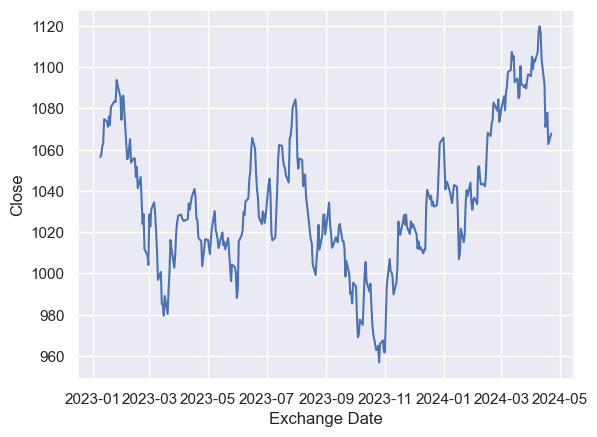

Series([], Name: Close, dtype: bool)


In [149]:
date = '2023-01-07'

df.set_index('Exchange Date', inplace=True)
filtered_df = df[df.index >= date].copy(deep=True)

plt.plot(filtered_df.index, filtered_df['Close'])
plt.xlabel('Exchange Date')
plt.ylabel('Close')
plt.show()

print(filtered_df['Close'].isnull()[filtered_df['Close'].isnull()])  
filtered_df.drop(['%Chg', 'Open', 'Low', 'High'], axis=1, inplace=True)

filtered_df.to_csv('new_filtered_data.csv')

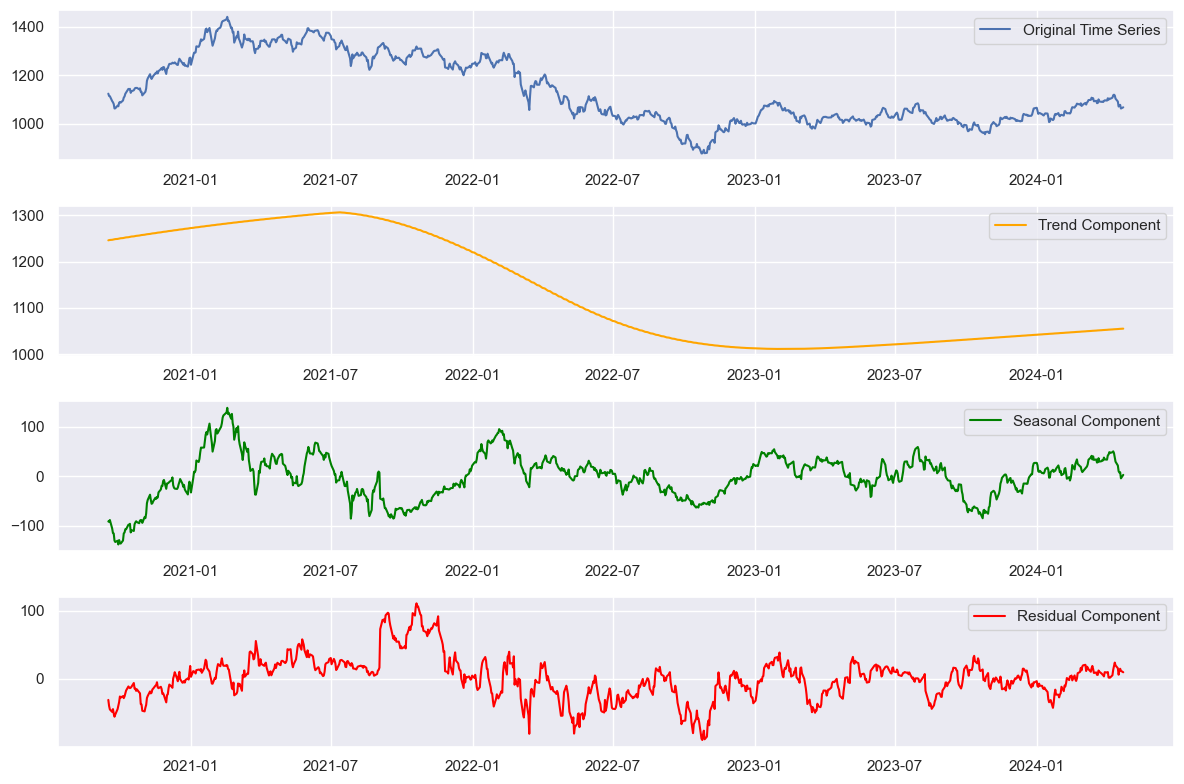

In [150]:
from statsmodels.tsa.seasonal import STL
# 252 for daily data
# 13 for monthly data
stl = STL(df['Close'], seasonal=13, period=252)  
result = stl.fit()

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['Close'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='orange')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red')
plt.legend()

plt.tight_layout()
plt.show()